# PGExplainer implementation using pytorch_geometric

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import os
from dataset import Tox21Dataset
from torch_geometric.explain import Explainer, PGExplainer, AttentionExplainer, DummyExplainer, GNNExplainer
from torch_geometric.loader import DataLoader, ImbalancedSampler
from torch_geometric.explain.metric import fidelity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

root_dir = os.getcwd()
data_dir = os.path.join(root_dir,'data_1')
ds = Tox21Dataset(root=data_dir, task=['NR-AhR'])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# GIN model

In [2]:
from models import simpleGIN

do = 0.2
num_layer = 3
num_hidden = 64

model = simpleGIN(in_channels=ds[0].x.size(1), dim_h=num_hidden, out_channels=ds[0].y.size(0), num_layers=num_layer, dropout=do)
state_dict = torch.load(os.path.join(root_dir, "models/final/GIN_best.pth"))['net']
model.load_state_dict(state_dict)
model.to(device)

simpleGIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=67, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
  ))
  (GIN_layers): ModuleList(
    (0-1): 2 x GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): ReLU()
    ))
  )
  (classifier): Sequential(
    (0): Linear(in_features=192, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [3]:
sampler = ImbalancedSampler(torch.tensor([0 if e==[1,0] else 1 for e in ds.y.view(-1,2)], dtype=torch.long))
loader = DataLoader(ds, batch_size=1, sampler=sampler)

## Dummy Explainer

In [4]:
topk_list = [1, 5, 10, 15, 20, 30, 40, 50]
result_summary_dummy_GIN =[]

for topk in topk_list:
    print(f'Topk={topk}, Start Dummy_Explainer')
    dummy_explainer = Explainer(
        model=model,
        algorithm=DummyExplainer(),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(mode='binary_classification', task_level='graph', return_type='raw'),
        threshold_config=dict(threshold_type='topk_hard', value=topk)
    )
    
    fidp_list = []
    fidm_list = []
    for i in tqdm(range(len(ds))):
        dummy_explanation = dummy_explainer(ds[i].x, ds[i].edge_index)
        fidp, fidm = fidelity(dummy_explainer, dummy_explanation)
        fidp_list.append(fidp)
        fidm_list.append(fidm)
    
    print(f'Result: fidelity_plus={np.mean(fidp_list):.4f}, fidelity_minus={np.mean(fidm_list):.4f}')
    result_summary_dummy_GIN.append({
        'model': "GIN",
        'method': "DummyExplainer",
        'topk': topk,
        'fidp': np.mean(fidp_list),
        'fidm': np.mean(fidm_list)
    })

GINDummyExp = pd.DataFrame(result_summary_dummy_GIN)
GINDummyExp.to_csv(os.path.join(os.getcwd(), "explain_results/GIN_dummy.csv"), index=False)

Topk=1, Start Dummy_Explainer


100%|██████████| 6542/6542 [00:10<00:00, 653.94it/s]


Result: fidelity_plus=0.0229, fidelity_minus=0.1056
Topk=5, Start Dummy_Explainer


 36%|███▋      | 2382/6542 [00:03<00:06, 679.39it/s]


KeyboardInterrupt: 

## GNNExplainer

In [5]:
topk_list = [1, 5, 10, 15, 20, 30, 40, 50]
result_summary_GNN_GIN =[]

for topk in topk_list:
    print(f'Topk={topk}, Start GNNExplainer')
    gnn_explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=50),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(mode='binary_classification', task_level='graph', return_type='raw'),
        threshold_config=dict(threshold_type='topk', value=topk)
    )
    
    fidp_list = []
    fidm_list = []
    for i in tqdm(range(len(ds))):
        gnn_explanation = gnn_explainer(ds[i].x, ds[i].edge_index)
        fidp, fidm = fidelity(gnn_explainer, gnn_explanation)
        fidp_list.append(fidp)
        fidm_list.append(fidm)
    
    print(f'Result: fidelity_plus={np.mean(fidp_list):.4f}, fidelity_minus={np.mean(fidm_list):.4f}')
    result_summary_GNN_GIN.append({
        'model': "GIN",
        'method': "GNNExplainer",
        'topk': topk,
        'fidp': np.mean(fidp_list),
        'fidm': np.mean(fidm_list)
    })

GINGNNExp = pd.DataFrame(result_summary_GNN_GIN)
GINGNNExp.to_csv(os.path.join(os.getcwd(), "explain_results/GIN_GNN.csv"), index=False)

Topk=1, Start GNNExplainer


100%|██████████| 6542/6542 [05:34<00:00, 19.58it/s]


Result: fidelity_plus=0.0219, fidelity_minus=0.1056
Topk=5, Start GNNExplainer


100%|██████████| 6542/6542 [05:33<00:00, 19.62it/s]


Result: fidelity_plus=0.0710, fidelity_minus=0.1056
Topk=10, Start GNNExplainer


  7%|▋         | 466/6542 [00:23<05:04, 19.95it/s]


KeyboardInterrupt: 

## Summary Plot

In [ ]:
GINDummyExp = pd.read_csv(os.path.join(os.getcwd(), "explain_results/GIN_Dummy.csv"))
GINGNNExp = pd.read_csv(os.path.join(os.getcwd(), "explain_results/GIN_GNN.csv"))

plt.plot(GINDummyExp['topk'], GINDummyExp['fidp'], 'bs-', label=r'$fid_+$ DummyExp')
plt.plot(GINDummyExp['topk'], GINDummyExp['fidm'], 'bs--', label=r'$fid_-$ DummyExp')
plt.plot(GINGNNExp['topk'], GINGNNExp['fidp'], 'go-', label=r'$fid_+$ GNNExp')
plt.plot(GINGNNExp['topk'], GINGNNExp['fidm'], 'go--', label=r'$fid_-$ GNNExp')
plt.xlabel('topk')
plt.ylabel('fidelity')
plt.legend()

## Try PGExplainer for one graph

In [18]:
from torch_geometric.explain import Explainer, PGExplainer
from torch_geometric.loader import DataLoader

loader = DataLoader(ds, batch_size=1, shuffle=True)

In [19]:
model.eval()
with torch.no_grad():
    for batch in loader:
        print(model(x=batch.x, edge_index=batch.edge_index))

tensor([[-2.0457,  1.6421]])
tensor([[ 4.7647, -3.8450]])
tensor([[ 5.0405, -4.4873]])
tensor([[ 2.8132, -2.2149]])
tensor([[ 1.2687, -0.7246]])
tensor([[ 5.0937, -3.9751]])
tensor([[11.6480, -8.8847]])
tensor([[ 3.2891, -2.9348]])
tensor([[ 3.6103, -2.9961]])
tensor([[ 0.8570, -1.1221]])
tensor([[ 9.0348, -6.9758]])
tensor([[ 3.7847, -3.1169]])
tensor([[ 2.3131, -2.1399]])
tensor([[ 3.2400, -3.6556]])
tensor([[ 2.7384, -3.0899]])
tensor([[ 1.2489, -0.9115]])
tensor([[ 0.8467, -0.7619]])
tensor([[ 3.5798, -3.1018]])
tensor([[10.7332, -8.5145]])
tensor([[ 4.2092, -2.8348]])
tensor([[ 1.9334, -1.5095]])
tensor([[ 1.5357, -1.3905]])
tensor([[ 0.8353, -0.5602]])
tensor([[ 0.0319, -0.1637]])
tensor([[ 3.7872, -3.2634]])
tensor([[-1.3140,  0.8330]])
tensor([[ 1.4879, -1.4619]])
tensor([[ 6.5227, -4.6524]])
tensor([[ 0.5385, -0.5526]])
tensor([[ 3.0544, -2.6627]])
tensor([[ 1.9006, -2.1222]])
tensor([[ 4.9828, -3.8715]])
tensor([[ 4.3145, -3.0286]])
tensor([[ 2.1311, -1.6290]])
tensor([[ 2.99

In [20]:
explainer = Explainer(
        model=model,
        algorithm=PGExplainer(epochs=30, lr=0.003),
        explanation_type='phenomenon',
        edge_mask_type='object',
        model_config=dict(
            mode='binary_classification',
            task_level='graph',
            return_type='raw'
        ),
        threshold_config=dict(threshold_type='topk', value=10)
    )

for epoch in range(30):
    for batch in loader:
        loss = explainer.algorithm.train(
            epoch, model, batch.x, batch.edge_index, target=batch.y)

KeyboardInterrupt: 

In [ ]:
explanation = explainer(ds[1].x, ds[1].edge_index, target=ds[1].y)
print(explanation.edge_mask)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


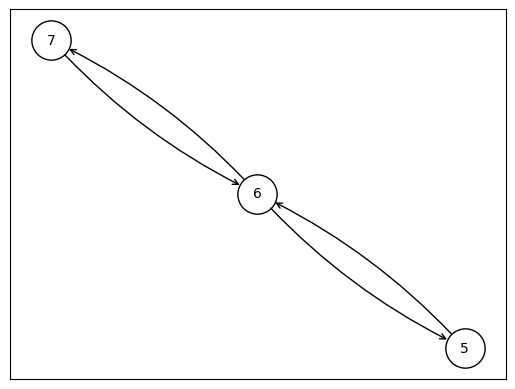

In [ ]:
explanation.visualize_graph()

In [ ]:
explanation.get_explanation_subgraph()

Explanation(edge_mask=[15], target=[2], x=[16, 67], edge_index=[2, 15])

## Generate Fidelity Curve for PGExplainer

In [ ]:
from torch_geometric.explain.metric import fidelity
import numpy as np

topk_list = [1, 5, 10, 15, 20, 30, 40, 50]
result_summary_GIN =[]

for topk in topk_list:
    print(f'Topk={topk}, Train PGExplainer')
    explainer = Explainer(
        model=model,
        algorithm=PGExplainer(epochs=30, lr=0.003),
        explanation_type='phenomenon',
        edge_mask_type='object',
        model_config=dict(
            mode='binary_classification',
            task_level='graph',
            return_type='raw'
        ),
        threshold_config=dict(threshold_type='topk', value=topk)
    )

    for epoch in range(30):
        for batch in loader:
            loss = explainer.algorithm.train(epoch, model, batch.x, batch.edge_index, target=batch.y)
    
    fidp_list = []
    fidm_list = []
    for i in range(len(ds)):
        explanation = explainer(ds[i].x, ds[i].edge_index, target=ds[i].y)
        fidp, fidm = fidelity(explainer, explanation)
        fidp_list.append(fidp)
        fidm_list.append(fidm)
    
    print(f'Result: fidelity_plus={np.mean(fidp_list):.4f}, fidelity_minus={np.mean(fidm_list):.4f}')
    result_summary_GIN.append({
        'method': "PGExplainer",
        'topk': topk,
        'fidp': np.mean(fidp_list),
        'fidm': np.mean(fidm_list)
    })

Topk=1, Train PGExplainer
Result: fidelity_plus=0.0255, fidelity_minus=0.1056
Topk=5, Train PGExplainer
Result: fidelity_plus=0.0000, fidelity_minus=0.1056
Topk=10, Train PGExplainer
Result: fidelity_plus=0.0912, fidelity_minus=0.1016
Topk=15, Train PGExplainer
Result: fidelity_plus=0.1015, fidelity_minus=0.0875
Topk=20, Train PGExplainer
Result: fidelity_plus=0.1042, fidelity_minus=0.0678


In [ ]:
result_summary_GIN

[{'method': 'PGExplainer',
  'topk': 1,
  'fidp': np.float64(0.02552736166309997),
  'fidm': np.float64(0.10562519107306634)},
 {'method': 'PGExplainer',
  'topk': 5,
  'fidp': np.float64(0.06863344542953226),
  'fidm': np.float64(0.10463161112809538)},
 {'method': 'PGExplainer',
  'topk': 10,
  'fidp': np.float64(0.09118006725771935),
  'fidm': np.float64(0.10157444206664629)},
 {'method': 'PGExplainer',
  'topk': 15,
  'fidp': np.float64(0.10149801284011006),
  'fidm': np.float64(0.08751146438398043)},
 {'method': 'PGExplainer',
  'topk': 20,
  'fidp': np.float64(0.10417303576887801),
  'fidm': np.float64(0.06779272393763375)},
 {'method': 'PGExplainer',
  'topk': 30,
  'fidp': np.float64(0.10379088963619688),
  'fidm': np.float64(0.05823907062060532)},
 {'method': 'PGExplainer',
  'topk': 40,
  'fidp': np.float64(0.10424946499541425),
  'fidm': np.float64(0.05671048608988077)},
 {'method': 'PGExplainer',
  'topk': 50,
  'fidp': np.float64(0.10333231427697952),
  'fidm': np.float64(0

In [ ]:
result_summary_GIN = [{'method': 'PGExplainer',
  'topk': 1,
  'fidp': np.float64(0.02552736166309997),
  'fidm': np.float64(0.10562519107306634)},
 {'method': 'PGExplainer',
  'topk': 5,
  'fidp': np.float64(0.06863344542953226),
  'fidm': np.float64(0.10463161112809538)},
 {'method': 'PGExplainer',
  'topk': 10,
  'fidp': np.float64(0.09118006725771935),
  'fidm': np.float64(0.10157444206664629)},
 {'method': 'PGExplainer',
  'topk': 15,
  'fidp': np.float64(0.10149801284011006),
  'fidm': np.float64(0.08751146438398043)},
 {'method': 'PGExplainer',
  'topk': 20,
  'fidp': np.float64(0.10417303576887801),
  'fidm': np.float64(0.06779272393763375)},
 {'method': 'PGExplainer',
  'topk': 30,
  'fidp': np.float64(0.10379088963619688),
  'fidm': np.float64(0.05823907062060532)},
 {'method': 'PGExplainer',
  'topk': 40,
  'fidp': np.float64(0.10424946499541425),
  'fidm': np.float64(0.05671048608988077)},
 {'method': 'PGExplainer',
  'topk': 50,
  'fidp': np.float64(0.10333231427697952),
  'fidm': np.float64(0.05564047691837359)}]

## Do the dummy explainer

In [ ]:
from torch_geometric.explain.metric import fidelity
import numpy as np

from torch_geometric.explain import Explainer, PGExplainer, DummyExplainer
from torch_geometric.loader import DataLoader

dummy_explainer = Explainer(
    model=model,

    algorithm=DummyExplainer(),
    explanation_type='phenomenon',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(mode='binary_classification', task_level='graph', return_type='raw'),
)


dummy_explanation = dummy_explainer(ds[0].x, ds[0].edge_index, target=ds[0].y)

In [ ]:
from torch_geometric.explain.metric import fidelity
import numpy as np

topk_list = [1, 5, 10, 15, 20, 30, 40, 50]
result_summary_dummy_GIN =[]

for topk in topk_list:
    print(f'Topk={topk}, Train Dummy Explainer')
    explainer = Explainer(
        model=model,
        algorithm=DummyExplainer(),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='binary_classification',
            task_level='graph',
            return_type='raw'
        ),
        threshold_config=dict(threshold_type='topk', value=topk)
    )
    
    fidp_list = []
    fidm_list = []
    for i in range(len(ds)):
        explanation = explainer(ds[i].x, ds[i].edge_index)
        fidp, fidm = fidelity(explainer, explanation)
        fidp_list.append(fidp)
        fidm_list.append(fidm)
    
    print(f'Result: fidelity_plus={np.mean(fidp_list):.4f}, fidelity_minus={np.mean(fidm_list):.4f}')
    result_summary_dummy_GIN.append({
        'method': "DummyExplainer",
        'topk': topk,
        'fidp': np.mean(fidp_list),
        'fidm': np.mean(fidm_list)
    })

Topk=1, Train Dummy Explainer
Result: fidelity_plus=0.0208, fidelity_minus=0.1056
Topk=5, Train Dummy Explainer
Result: fidelity_plus=0.0520, fidelity_minus=0.1056
Topk=10, Train Dummy Explainer
Result: fidelity_plus=0.0773, fidelity_minus=0.1056
Topk=15, Train Dummy Explainer
Result: fidelity_plus=0.0926, fidelity_minus=0.1056
Topk=20, Train Dummy Explainer
Result: fidelity_plus=0.0973, fidelity_minus=0.1056
Topk=30, Train Dummy Explainer
Result: fidelity_plus=0.1036, fidelity_minus=0.1056
Topk=40, Train Dummy Explainer
Result: fidelity_plus=0.1035, fidelity_minus=0.1056
Topk=50, Train Dummy Explainer
Result: fidelity_plus=0.1052, fidelity_minus=0.1056


In [ ]:
explanation.node_mask

AttributeError: 'GlobalStorage' object has no attribute 'node_mask'

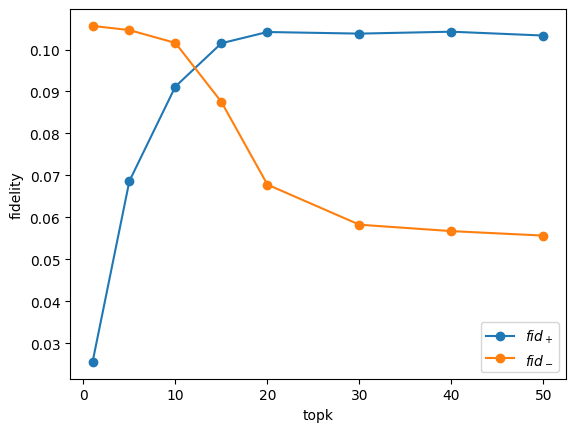

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pgExplainer = pd.DataFrame(result_summary_GIN)
plt.plot(pgExplainer['topk'], pgExplainer['fidp'], 'o-', label=r'$fid_+$')
plt.plot(pgExplainer['topk'], pgExplainer['fidm'], 'o-', label=r'$fid_-$')
plt.xlabel('topk')
plt.ylabel('fidelity')
plt.legend()

# GAT model

Load model

In [2]:
from models import simpleGAT

do = 0.4
num_layer = 4
num_hidden = 64

model = simpleGAT(in_channels=ds[0].x.size(1), dim_h=num_hidden, out_channels=ds[0].y.size(0), num_layers=num_layer, heads=4, dropout=do)
state_dict = torch.load(os.path.join(root_dir, "models/final/GAT_best.pth"))['net']
model.load_state_dict(state_dict)
model.to(device)


simpleGAT(
  (conv1): GATConv(67, 64, heads=4)
  (GAT_layers): ModuleList(
    (0-2): 3 x GATConv(256, 64, heads=4)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [3]:
sampler = ImbalancedSampler(torch.tensor([0 if e==[1,0] else 1 for e in ds.y.view(-1,2)], dtype=torch.long))
loader = DataLoader(ds, batch_size=1, sampler=sampler)

## PGExplainer

In [4]:
from torch_geometric.explain.metric import fidelity
import numpy as np

topk_list = [1, 5, 10, 15, 20, 30, 40, 50]
result_summary_GAT =[]

for topk in topk_list:
    print(f'Topk={topk}, Train PGExplainer')
    explainer = Explainer(
        model=model,
        algorithm=PGExplainer(epochs=30, lr=0.003),
        explanation_type='phenomenon',
        edge_mask_type='object',
        model_config=dict(
            mode='binary_classification',
            task_level='graph',
            return_type='raw'
        ),
        threshold_config=dict(threshold_type='topk', value=topk)
    )

    for epoch in range(30):
        for batch in loader:
            loss = explainer.algorithm.train(epoch, model, batch.x, batch.edge_index, target=batch.y)
    
    fidp_list = []
    fidm_list = []
    for i in range(len(ds)):
        explanation = explainer(ds[i].x, ds[i].edge_index, target=ds[i].y)
        fidp, fidm = fidelity(explainer, explanation)
        fidp_list.append(fidp)
        fidm_list.append(fidm)
    
    print(f'Result: fidelity_plus={np.mean(fidp_list):.4f}, fidelity_minus={np.mean(fidm_list):.4f}')
    result_summary_GAT.append({
        'method': "PGExplainer",
        'topk': topk,
        'fidp': np.mean(fidp_list),
        'fidm': np.mean(fidm_list)
    })

Topk=1, Train PGExplainer
Result: fidelity_plus=0.0000, fidelity_minus=0.8536
Topk=5, Train PGExplainer
Result: fidelity_plus=0.0000, fidelity_minus=0.8536
Topk=10, Train PGExplainer
Result: fidelity_plus=0.0000, fidelity_minus=0.8536
Topk=15, Train PGExplainer
Result: fidelity_plus=0.0000, fidelity_minus=0.8536
Topk=20, Train PGExplainer
Result: fidelity_plus=0.0000, fidelity_minus=0.8536
Topk=30, Train PGExplainer
Result: fidelity_plus=0.0000, fidelity_minus=0.8536
Topk=40, Train PGExplainer
Result: fidelity_plus=0.0000, fidelity_minus=0.8536
Topk=50, Train PGExplainer
Result: fidelity_plus=0.0000, fidelity_minus=0.8536


In [ ]:
explainer = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=10, lr=0.003),
    explanation_type='phenomenon',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='raw'
    ),
    # threshold_config=dict(threshold_type='topk', value=50)
)

for epoch in range(10):
    for batch in loader:
        loss = explainer.algorithm.train(epoch, model, batch.x, batch.edge_index, target=batch.y)

In [6]:
explanation = explainer(ds[0].x, ds[0].edge_index, target=ds[0].y)
print(explanation.edge_mask)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [ ]:
fidelity(explainer, explanation)

(0.0, 1.0)

In [9]:
for i in range(100):
    explanation = explainer(ds[i].x, ds[i].edge_index, target=ds[i].y)
    print(fidelity(explainer, explanation))
    print(explanation.edge_mask)

(0.0, 1.0)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
(0.0, 1.0)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
(0.0, 1.0)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
(0.0, 0.0)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
(0.0, 1.0)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
(0.0, 1.0)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
(0.0, 1.0)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0

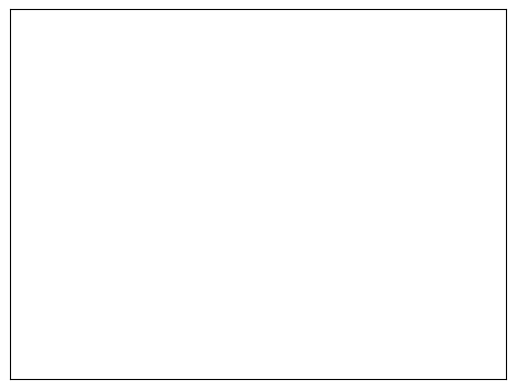

In [27]:
explanation.visualize_graph()

In [25]:
explainer = Explainer(
    model=model,
    algorithm=GraphMaskExplainer(2, epochs=5),
    explanation_type='phenomenon',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='raw',
    ),
)

explanation = explainer(ds[0].x, ds[0].edge_index, target=ds[0].y)

IndexError: list index out of range

## AttentionExplainer

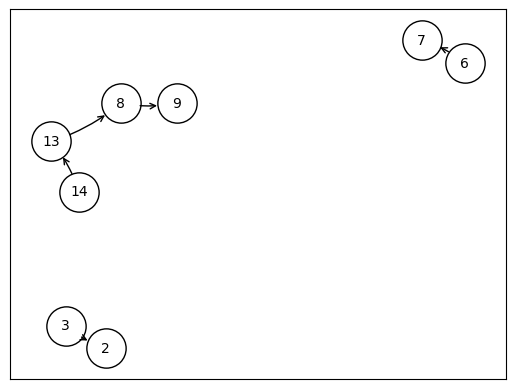

(1.0, 1.0)


In [4]:
attention_explainer = Explainer(
    model=model,
    # AttentionExplainer takes an optional reduce parameter. The reduce parameter
    # allows you to set how you want to aggregate attention coefficients over layers
    # and heads. The explainer will then aggregate these values using this
    # given method to determine the edge_mask (we use the default 'max' here).
    algorithm=AttentionExplainer(),
    explanation_type='model',
    # Like PGExplainer, AttentionExplainer also does not support node_mask_type
    edge_mask_type='object',
    model_config=dict(mode='binary_classification', task_level='graph', return_type='raw'),
    threshold_config=dict(threshold_type='topk', value=5)
)

attention_explanation = attention_explainer(ds[0].x, ds[0].edge_index)
attention_explanation.visualize_graph()
print(fidelity(attention_explainer, attention_explanation))

In [5]:
topk_list = [1, 5, 10, 15, 20, 30, 40, 50]
result_summary_GAT =[]

for topk in topk_list:
    print(f'Topk={topk}, Start Attention_Explainer')
    attention_explainer = Explainer(
        model=model,
        # AttentionExplainer takes an optional reduce parameter. The reduce parameter
        # allows you to set how you want to aggregate attention coefficients over layers
        # and heads. The explainer will then aggregate these values using this
        # given method to determine the edge_mask (we use the default 'max' here).
        algorithm=AttentionExplainer(),
        explanation_type='model',
        # Like PGExplainer, AttentionExplainer also does not support node_mask_type
        edge_mask_type='object',
        model_config=dict(mode='binary_classification', task_level='graph', return_type='raw'),
        threshold_config=dict(threshold_type='topk', value=topk)
    )
    
    fidp_list = []
    fidm_list = []
    for i in tqdm(range(len(ds))):
        attention_explanation = attention_explainer(ds[i].x, ds[i].edge_index)
        fidp, fidm = fidelity(attention_explainer, attention_explanation)
        fidp_list.append(fidp)
        fidm_list.append(fidm)
    
    print(f'Result: fidelity_plus={np.mean(fidp_list):.4f}, fidelity_minus={np.mean(fidm_list):.4f}')
    result_summary_GAT.append({
        'model': 'GAT',
        'method': "AttentionExplainer",
        'topk': topk,
        'fidp': np.mean(fidp_list),
        'fidm': np.mean(fidm_list)
    })

GATAttExp = pd.DataFrame(result_summary_GAT)
GATAttExp.to_csv(os.path.join(os.getcwd(), "explain_results/GAT_Att.csv"), index=False)

Topk=1, Start Attention_Explainer


100%|██████████| 6542/6542 [00:21<00:00, 300.32it/s]


Result: fidelity_plus=0.0283, fidelity_minus=0.8546
Topk=5, Start Attention_Explainer


100%|██████████| 6542/6542 [00:21<00:00, 297.89it/s]


Result: fidelity_plus=0.1019, fidelity_minus=0.7284
Topk=10, Start Attention_Explainer


100%|██████████| 6542/6542 [00:21<00:00, 300.99it/s]


Result: fidelity_plus=0.1376, fidelity_minus=0.5723
Topk=15, Start Attention_Explainer


100%|██████████| 6542/6542 [00:21<00:00, 303.07it/s]


Result: fidelity_plus=0.1664, fidelity_minus=0.4608
Topk=20, Start Attention_Explainer


100%|██████████| 6542/6542 [00:22<00:00, 292.74it/s]


Result: fidelity_plus=0.1989, fidelity_minus=0.3843
Topk=30, Start Attention_Explainer


100%|██████████| 6542/6542 [00:21<00:00, 305.71it/s]


Result: fidelity_plus=0.2463, fidelity_minus=0.2878
Topk=40, Start Attention_Explainer


100%|██████████| 6542/6542 [00:20<00:00, 312.42it/s]


Result: fidelity_plus=0.2885, fidelity_minus=0.2281
Topk=50, Start Attention_Explainer


100%|██████████| 6542/6542 [00:21<00:00, 304.44it/s]

Result: fidelity_plus=0.3174, fidelity_minus=0.1945


## Dummy Explainer

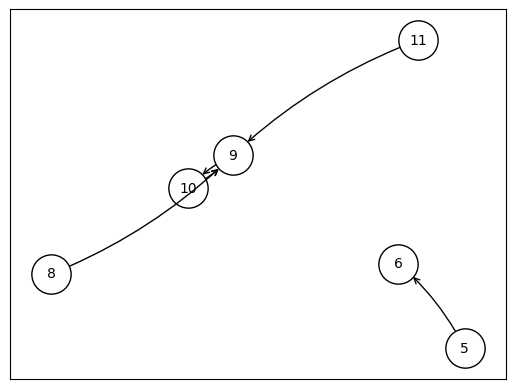

(1.0, 1.0)


In [6]:
dummy_explainer = Explainer(
    model=model,
    algorithm=DummyExplainer(),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(mode='binary_classification', task_level='graph', return_type='raw'),
    threshold_config=dict(threshold_type='topk', value=5)
)

dummy_explanation = dummy_explainer(ds[0].x, ds[0].edge_index)
dummy_explanation.visualize_graph()
print(fidelity(dummy_explainer, dummy_explanation))

In [7]:
topk_list = [1, 5, 10, 15, 20, 30, 40, 50]
result_summary_dummy_GAT =[]

for topk in topk_list:
    print(f'Topk={topk}, Start Dummy_Explainer')
    dummy_explainer = Explainer(
        model=model,
        algorithm=DummyExplainer(),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(mode='binary_classification', task_level='graph', return_type='raw'),
        threshold_config=dict(threshold_type='topk', value=topk)
    )
    
    fidp_list = []
    fidm_list = []
    for i in tqdm(range(len(ds))):
        dummy_explanation = dummy_explainer(ds[i].x, ds[i].edge_index)
        fidp, fidm = fidelity(dummy_explainer, dummy_explanation)
        fidp_list.append(fidp)
        fidm_list.append(fidm)
    
    print(f'Result: fidelity_plus={np.mean(fidp_list):.4f}, fidelity_minus={np.mean(fidm_list):.4f}')
    result_summary_dummy_GAT.append({
        'model': 'GAT',
        'method': "DummyExplainer",
        'topk': topk,
        'fidp': np.mean(fidp_list),
        'fidm': np.mean(fidm_list)
    })

GATDummyExp = pd.DataFrame(result_summary_dummy_GAT)
GATDummyExp.to_csv(os.path.join(os.getcwd(), "explain_results/GAT_Dummy.csv"), index=False)

Topk=1, Start Dummy_Explainer


100%|██████████| 6542/6542 [00:16<00:00, 389.82it/s]


Result: fidelity_plus=0.0183, fidelity_minus=0.8960
Topk=5, Start Dummy_Explainer


100%|██████████| 6542/6542 [00:16<00:00, 387.93it/s]


Result: fidelity_plus=0.0571, fidelity_minus=0.8786
Topk=10, Start Dummy_Explainer


100%|██████████| 6542/6542 [00:16<00:00, 395.34it/s]


Result: fidelity_plus=0.1022, fidelity_minus=0.8230
Topk=15, Start Dummy_Explainer


100%|██████████| 6542/6542 [00:16<00:00, 393.19it/s]


Result: fidelity_plus=0.1396, fidelity_minus=0.7680
Topk=20, Start Dummy_Explainer


100%|██████████| 6542/6542 [00:16<00:00, 387.37it/s]


Result: fidelity_plus=0.1772, fidelity_minus=0.7096
Topk=30, Start Dummy_Explainer


100%|██████████| 6542/6542 [00:16<00:00, 394.62it/s]


Result: fidelity_plus=0.2362, fidelity_minus=0.6535
Topk=40, Start Dummy_Explainer


100%|██████████| 6542/6542 [00:16<00:00, 401.26it/s]


Result: fidelity_plus=0.2562, fidelity_minus=0.6420
Topk=50, Start Dummy_Explainer


100%|██████████| 6542/6542 [00:16<00:00, 402.11it/s]

Result: fidelity_plus=0.2826, fidelity_minus=0.6142


## GNNExplainer

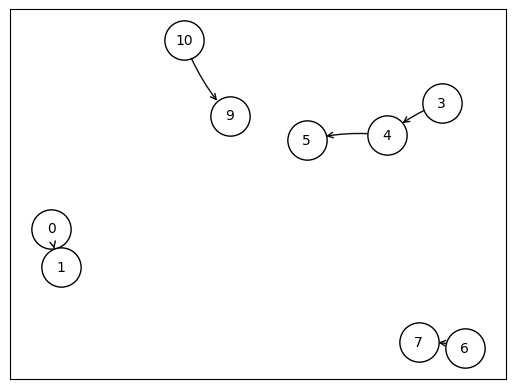

(1.0, 1.0)


In [4]:
gnn_explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=50),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(mode='binary_classification', task_level='graph', return_type='raw'),
    threshold_config=dict(threshold_type='topk', value=5)
)

gnn_explanation = gnn_explainer(ds[0].x, ds[0].edge_index)
gnn_explanation.visualize_graph()
print(fidelity(gnn_explainer, gnn_explanation))

In [5]:
topk_list = [1, 5, 10, 15, 20, 30, 40, 50]
result_summary_GNN_GAT =[]

for topk in topk_list:
    print(f'Topk={topk}, Start GNNExplainer')
    gnn_explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=50),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(mode='binary_classification', task_level='graph', return_type='raw'),
        threshold_config=dict(threshold_type='topk', value=topk)
    )
    
    fidp_list = []
    fidm_list = []
    for i in tqdm(range(len(ds))):
        gnn_explanation = gnn_explainer(ds[i].x, ds[i].edge_index)
        fidp, fidm = fidelity(gnn_explainer, gnn_explanation)
        fidp_list.append(fidp)
        fidm_list.append(fidm)
    
    print(f'Result: fidelity_plus={np.mean(fidp_list):.4f}, fidelity_minus={np.mean(fidm_list):.4f}')
    result_summary_GNN_GAT.append({
        'model': 'GAT',
        'method': "GNNExplainer",
        'topk': topk,
        'fidp': np.mean(fidp_list),
        'fidm': np.mean(fidm_list)
    })

GATGNNExp = pd.DataFrame(result_summary_GNN_GAT)
GATGNNExp.to_csv(os.path.join(os.getcwd(), "explain_results/GAT_GNN.csv"), index=False)

Topk=1, Start GNNExplainer


100%|██████████| 6542/6542 [09:26<00:00, 11.55it/s]


Result: fidelity_plus=0.0417, fidelity_minus=0.8928
Topk=5, Start GNNExplainer


100%|██████████| 6542/6542 [10:30<00:00, 10.38it/s]


Result: fidelity_plus=0.2299, fidelity_minus=0.8275
Topk=10, Start GNNExplainer


100%|██████████| 6542/6542 [10:50<00:00, 10.06it/s]


Result: fidelity_plus=0.4718, fidelity_minus=0.6585
Topk=15, Start GNNExplainer


100%|██████████| 6542/6542 [10:53<00:00, 10.02it/s]


Result: fidelity_plus=0.6526, fidelity_minus=0.4551
Topk=20, Start GNNExplainer


100%|██████████| 6542/6542 [11:37<00:00,  9.38it/s]


Result: fidelity_plus=0.7511, fidelity_minus=0.3129
Topk=30, Start GNNExplainer


100%|██████████| 6542/6542 [11:53<00:00,  9.18it/s]


Result: fidelity_plus=0.8305, fidelity_minus=0.1347
Topk=40, Start GNNExplainer


100%|██████████| 6542/6542 [11:43<00:00,  9.29it/s]


Result: fidelity_plus=0.8591, fidelity_minus=0.0550
Topk=50, Start GNNExplainer


100%|██████████| 6542/6542 [11:16<00:00,  9.67it/s]

Result: fidelity_plus=0.8598, fidelity_minus=0.0368


## Summary Graph

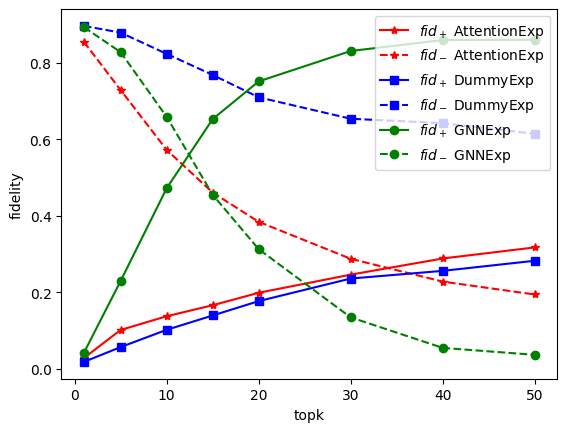

In [8]:
GATAttExp = pd.read_csv(os.path.join(os.getcwd(), "explain_results/GAT_Att.csv"))
GATDummyExp = pd.read_csv(os.path.join(os.getcwd(), "explain_results/GAT_Dummy.csv"))
GATGNNExp = pd.read_csv(os.path.join(os.getcwd(), "explain_results/GAT_GNN.csv"))

plt.plot(GATAttExp['topk'], GATAttExp['fidp'], 'r*-', label=r'$fid_+$ AttentionExp')
plt.plot(GATAttExp['topk'], GATAttExp['fidm'], 'r*--', label=r'$fid_-$ AttentionExp')
plt.plot(GATDummyExp['topk'], GATDummyExp['fidp'], 'bs-', label=r'$fid_+$ DummyExp')
plt.plot(GATDummyExp['topk'], GATDummyExp['fidm'], 'bs--', label=r'$fid_-$ DummyExp')
plt.plot(GATGNNExp['topk'], GATGNNExp['fidp'], 'go-', label=r'$fid_+$ GNNExp')
plt.plot(GATGNNExp['topk'], GATGNNExp['fidm'], 'go--', label=r'$fid_-$ GNNExp')
plt.xlabel('topk')
plt.ylabel('fidelity')
plt.legend()

# Do the same for MPNN

In [2]:
from models import MPNNModel

do = 0.2
num_layer = 2
num_hidden = 64


model = MPNNModel(node_dim=ds[0].x.size(1), edge_dim=ds[0].edge_attr.size(1), hidden_dim=num_hidden, num_layers=num_layer, dropout=do)
state_dict = torch.load(os.path.join(root_dir, "models/final/MPNN_best.pth"))['net']
model.load_state_dict(state_dict)
model.to(device)

loader = DataLoader(ds, batch_size=1, shuffle=True)

In [3]:
sampler = ImbalancedSampler(torch.tensor([0 if e==[1,0] else 1 for e in ds.y.view(-1,2)], dtype=torch.long))
loader = DataLoader(ds, batch_size=1, sampler=sampler)

## Dummy Explainer

In [4]:
topk_list = [1, 5, 10, 15, 20, 30, 40, 50]
result_summary_dummy_MPNN =[]

for topk in topk_list:
    print(f'Topk={topk}, Start Dummy_Explainer')
    dummy_explainer = Explainer(
        model=model,
        algorithm=DummyExplainer(),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(mode='binary_classification', task_level='graph', return_type='raw'),
        threshold_config=dict(threshold_type='topk', value=topk)
    )
    
    fidp_list = []
    fidm_list = []
    for i in tqdm(range(len(ds))):
        dummy_explanation = dummy_explainer(ds[i].x, ds[i].edge_index)
        fidp, fidm = fidelity(dummy_explainer, dummy_explanation)
        fidp_list.append(fidp)
        fidm_list.append(fidm)
    
    print(f'Result: fidelity_plus={np.mean(fidp_list):.4f}, fidelity_minus={np.mean(fidm_list):.4f}')
    result_summary_dummy_MPNN.append({
        'model': 'MPNN',
        'method': "DummyExplainer",
        'topk': topk,
        'fidp': np.mean(fidp_list),
        'fidm': np.mean(fidm_list)
    })

MPNNDummyExp = pd.DataFrame(result_summary_dummy_MPNN)
MPNNDummyExp.to_csv(os.path.join(os.getcwd(), "explain_results/MPNN_Dummy.csv"), index=False)

Topk=1, Start Dummy_Explainer


  0%|          | 0/6542 [00:00<?, ?it/s]


TypeError: expected Tensor as element 2 in argument 0, but got NoneType

## GNN Explainer

In [5]:
topk_list = [1, 5, 10, 15, 20, 30, 40, 50]
result_summary_GNN_MPNN =[]

for topk in topk_list:
    print(f'Topk={topk}, Start GNNExplainer')
    gnn_explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=50),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(mode='binary_classification', task_level='graph', return_type='raw'),
        threshold_config=dict(threshold_type='topk', value=topk)
    )
    
    fidp_list = []
    fidm_list = []
    for i in tqdm(range(len(ds))):
        gnn_explanation = gnn_explainer(ds[i].x, ds[i].edge_index)
        fidp, fidm = fidelity(gnn_explainer, gnn_explanation)
        fidp_list.append(fidp)
        fidm_list.append(fidm)
    
    print(f'Result: fidelity_plus={np.mean(fidp_list):.4f}, fidelity_minus={np.mean(fidm_list):.4f}')
    result_summary_GNN_MPNN.append({
        'model': 'MPNN',
        'method': "GNNExplainer",
        'topk': topk,
        'fidp': np.mean(fidp_list),
        'fidm': np.mean(fidm_list)
    })

MPNNGNNExp = pd.DataFrame(result_summary_GNN_MPNN)
MPNNGNNExp.to_csv(os.path.join(os.getcwd(), "explain_results/MPNN_GNN.csv"), index=False)

Topk=1, Start GNNExplainer


  0%|          | 0/6542 [00:00<?, ?it/s]


TypeError: expected Tensor as element 2 in argument 0, but got NoneType

## Summary Plot

In [ ]:
MPNNDummyExp = pd.read_csv(os.path.join(os.getcwd(), "explain_results/MPNN_Dummy.csv"))
MPNNGNNExp = pd.read_csv(os.path.join(os.getcwd(), "explain_results/MPNN_GNN.csv"))

plt.plot(MPNNDummyExp['topk'], MPNNDummyExp['fidp'], 'bs-', label=r'$fid_+$ DummyExp')
plt.plot(MPNNDummyExp['topk'], MPNNDummyExp['fidm'], 'bs--', label=r'$fid_-$ DummyExp')
plt.plot(MPNNGNNExp['topk'], MPNNGNNExp['fidp'], 'go-', label=r'$fid_+$ GNNExp')
plt.plot(MPNNGNNExp['topk'], MPNNGNNExp['fidm'], 'go--', label=r'$fid_-$ GNNExp')
plt.xlabel('topk')
plt.ylabel('fidelity')
plt.legend()